In [1]:
__author__ = 'Linda Jaber, CUSP NYU 2018'
from __future__ import print_function

import sys
import os
try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%pylab inline


import requests
import json
import io

import shapely
from fiona.crs import from_epsg
import pysal as ps

pylab.rcParams['figure.figsize'] = 12, 8
pylab.rcParams['figure.dpi'] = 100

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIdata = os.getenv('PUIDATA')
if PUIdata is None:
    os.environ['PUIDATA']='%s/PUIdata'%os.getenv('HOME')
    PUIdata = os.getenv('PUIDATA')
print('PUIdata: ', PUIdata) 

PUIdata:  /nfshome/lj1232/PUIdata


### 1. PUMA : Public Use Microdata Area
### 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry fron the NYC Open Data API and read it in with geopandas
https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

In [3]:
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
#shapefile = urllib.urlretrieve(url, 'file.gz' )
#!unzip file.gz -d $PUIdata/PUMA_NYC_shapefile
!ls $PUIdata/PUMA_NYC_shapefile

geo_export_bd2fd15c-479c-4ec4-80a9-e992aaf12623.dbf
geo_export_bd2fd15c-479c-4ec4-80a9-e992aaf12623.prj
geo_export_bd2fd15c-479c-4ec4-80a9-e992aaf12623.shp
geo_export_bd2fd15c-479c-4ec4-80a9-e992aaf12623.shx


In [4]:
pumashp = gpd.GeoDataFrame.from_file(PUIdata + '/PUMA_NYC_shapefile/geo_export_bd2fd15c-479c-4ec4-80a9-e992aaf12623.shp')
pumashp.puma = pumashp.puma.astype(int)
pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [5]:
pumashp.crs

{'init': 'epsg:4326'}

### 1.2 plot the PUMA NYC regions

Text(0.5,1,'Public Use Microdata Area (PUMA) Boundaries for New York City')

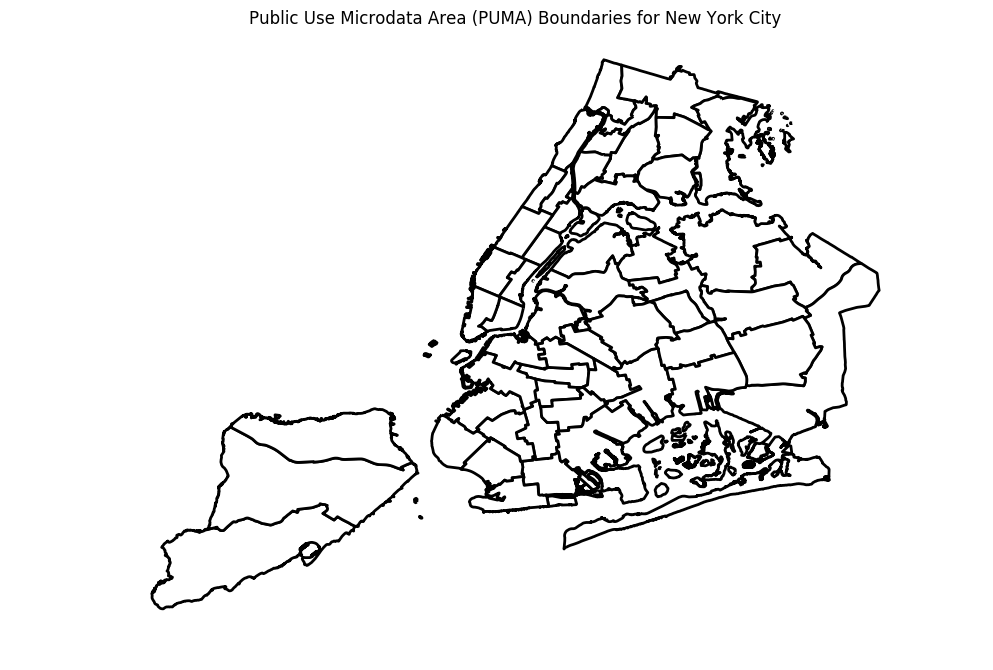

In [6]:
ax = pumashp.plot(color='white', edgecolor='black', lw=2)

ax.axes.set_aspect('equal', 'datalim')
ax.axis('off')

plt.title('Public Use Microdata Area (PUMA) Boundaries for New York City')

**Figure1:** Public Use Microdata Area (PUMA) Boundaries for New York City. NYC is divided in 55 PUMAs ranging in size reflecting the population density variations in NYC (since PUMAs are constructed to collect a fix number of inhabitants).

In [7]:
len(pumashp)

55

### 2. American Fact Finder data on percentage of houses with broadband internet access
### 2.1 Get data with American Fact Finder (AFF) API:

In [8]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
from censusAPI import myAPI

**You can find out what are the features that you can query through the API for the annually surveyed data at this url:**
https://api.census.gov/data/2016/acs/acs1/variables.json

In [9]:
url = 'https://api.census.gov/data/2016/acs/acs1/variables.json'
response = requests.request('GET', url)
aff1y = json.loads(response.text)

In [10]:
aff1y.keys()

dict_keys(['variables'])

In [11]:
type(aff1y['variables'])

dict

In [12]:
# https://api.census.gov/data/2017/acs/acs1/variables.html used this link to check the list of variables
aff1y['variables']['B28002_004E']

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

**You need two features: total number of households, and number of households with broadband access**

**Broadband access is one of the B28002 keys. However there are many of those! Each variable has several observations associated to it: B28002 is all internet access data (broadband, dial up, none, ...), and for each of those you have the estimate (count, mean, median, percentage...), the margin of errors, and annotations. Those are identified by an appendix that begins with "_". Look carefully at the line of code below and its output. I am creating a list that contains the keys of the dictionary I created from the json file for all B28002 observations (rows that start with "B28002") that include the word "Broadband" in the description.**

In [13]:
#turning things into arrays to enable broadcasting
affkeys = np.array(list(aff1y['variables'].keys()))

In [14]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label']) \
for k in affkeys if k.startswith ('B28002') \
and 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

**Choose the appropriate variable and extract the relevant data: below I select the variable containing the number of household per PUMA. The "all" variable, which tells you what is the total number of units queried (households here) is generally stored in the _001 variable (B28002_001 in this case). "E" stands for estimate. M stands for margin of error, EA estimate annotations, MA margin of error annotations. You want the estimate for this exercise.**

In [15]:
#key for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [16]:
#key for the number of households with broadband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

**The API url is as follows:**

root: https://api.census.gov/data/2016/acs/acs1

action: get=[variable Name],NAME

geometry: for=[geometry]:[desired geometry values]in=[larger geometry]:[desired larger geometry values]

API key: key:[api key]

the URL is constructed as root?action&geometry&key

Note that it took me a long time to figure out how to request the right geometry: in the url I write below the geometry is "public%20use%20microdata%20area" where %20 is the character for ' ' (space) in a url, and ":*" means all PUMAS

state:36 is New York State

In [17]:
# getting the broadband access number of households
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + keyNBB + \
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + myAPI
response = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(response.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [18]:
# getting the first row of the table: the total number of households
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + keyNhouseholds + \
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + myAPI
response = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(response.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


### 2.2 generate a feature for the percentage of households with broadband access

In [19]:
#merge
pumaBB = pumaBB.merge(pumaPP, on='NAME')
pumaBB.head()

,B28002_004E,NAME,state_x,public use microdata area_x,Unnamed: 4_x,B28002_001E,state_y,public use microdata area_y,Unnamed: 4_y
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,36,402,NaN


In [20]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state_x', 'public use microdata area_x',
       'Unnamed: 4_x', 'B28002_001E', 'state_y', 'public use microdata area_y',
       'Unnamed: 4_y'],
      dtype='object')

In [21]:
#drop
pumaBB.drop(['Unnamed: 4_x', 'state_y','public use microdata area_y', 
             'Unnamed: 4_y'], axis=1, inplace=True)

In [22]:
pumaBB.head()

,B28002_004E,NAME,state_x,public use microdata area_x,B28002_001E
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [23]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state_x', 'public use microdata area_x',
       'B28002_001E'],
      dtype='object')

In [24]:
#Rename
pumaBB.columns = ['NBB', 'NAME', 'state', 'public use microdata area',
       'Nhouseholds']
pumaBB.head()

,NBB,NAME,state,public use microdata area,Nhouseholds
0,32607,"St. Lawrence County PUMA, New York",36,100,40479
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146


In [25]:
# add a new column for the percentage of households with broadband access 
# NBB: number of huoseholds with broadband internet
# Nhouseholds: total number of households
# pcBB: percentage of households with broadband access
pumaBB['pcBB'] = pumaBB['NBB'] / pumaBB['Nhouseholds'] * 100
pumaBB.head()

,NBB,NAME,state,public use microdata area,Nhouseholds,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,61146,78.150656


In [26]:
type(pumaBB.NBB[0])

numpy.int64

In [27]:
type(pumaBB.pcBB[0])

numpy.float64

### 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above.
https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_1YR_GCT2801.ST50&prodType=table

In [28]:
#!unzip ACS_16_1YR_GCT2801.ST50.zip -d $PUIdata/ACS_16_1YR_GCT2801
!ls $PUIdata/ACS_16_1YR_GCT2801

ACS_16_1YR_GCT2801.ST50_metadata.csv  ACS_16_1YR_GCT2801.ST50_with_ann.csv
ACS_16_1YR_GCT2801.ST50.txt	      aff_download_readme_ann.txt


In [29]:
pd.read_csv(PUIdata + '/ACS_16_1YR_GCT2801/ACS_16_1YR_GCT2801.ST50_with_ann.csv' ).head()

,GEO.id,GEO.id2,GEO.display-label,GCT_STUB.target-geo-id,GCT_STUB.target-geo-id2,GCT_STUB.display-label,GCT_STUB.display-label.1,HC01,HC02
0,Id,Id2,Geography,Target Geo Id,Target Geo Id2,Geographic Area,Geographic Area,Percent,Margin of Error
1,0400000US36,36,New York,0400000US36,36,New York,New York,81.7,0.2
2,0400000US36,36,New York,7950000US3600100,3600100,New York - St. Lawrence County PUMA,St. Lawrence County PUMA,80.6,2.6
3,0400000US36,36,New York,7950000US3600200,3600200,"New York - Clinton, Franklin, Essex & Hamilton...","Clinton, Franklin, Essex & Hamilton Counties PUMA",75.7,2.2
4,0400000US36,36,New York,7950000US3600300,3600300,New York - Warren & Washington Counties PUMA,Warren & Washington Counties PUMA,79.8,2.6


In [30]:
bbpc = pd.read_csv(PUIdata + '/ACS_16_1YR_GCT2801/ACS_16_1YR_GCT2801.ST50_with_ann.csv', skiprows=[0], usecols=['Target Geo Id2', 'Percent', 'Margin of Error'])
bbpc.columns=['public use microdata area', 'Percent', 'Margin of Error']
bbpc['public use microdata area'] = bbpc['public use microdata area']-3600000
bbpc.head()

,public use microdata area,Percent,Margin of Error
0,-3599964,81.7,0.2
1,100,80.6,2.6
2,200,75.7,2.2
3,300,79.8,2.6
4,401,81.4,2.4


In [31]:
len(bbpc)

146

In [32]:
type(bbpc['public use microdata area'][0])

numpy.int64

#### check that the percentage of households with broadband you generated and the one you read in from the table you downloaded manually are the same

In [33]:
comp = pumaBB.merge(bbpc, on='public use microdata area')[['pcBB', 'Percent']]
comp['diff'] = np.abs(comp['pcBB'] - comp['Percent'])
comp.tail()

,pcBB,Percent,diff
140,82.579178,82.6,0.020822
141,83.841021,83.8,0.041021
142,76.787748,76.8,0.012252
143,85.546608,85.5,0.046608
144,77.770257,77.8,0.029743


In [34]:
comp.describe()

,pcBB,Percent,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


**The maximum difference in percentages is very small**

### 3 Plot a choropleth of NYC broadband access
#### 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [35]:
pumashp = pumashp.merge(pumaBB, left_on='puma', right_on='public use microdata area')
pumashp.head()

,puma,shape_area,shape_leng,geometry,NBB,NAME,state,public use microdata area,Nhouseholds,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618


Text(0.5,1,'Percentage of Households with Broadband Internet Access (PUMA)')

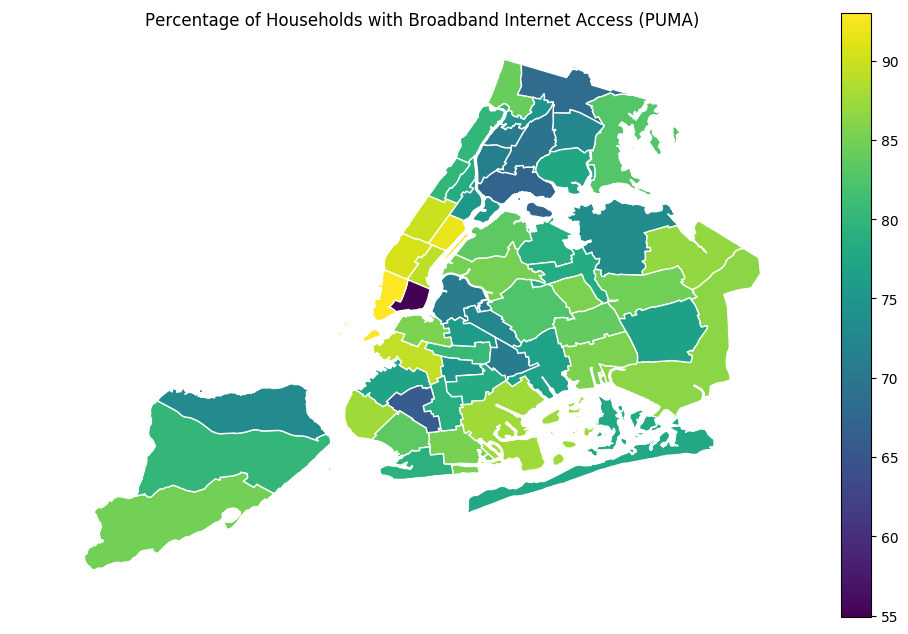

In [36]:
ax = pumashp.plot(column='pcBB', legend=True, edgecolor='white')
ax.axis('off')
plt.title('Percentage of Households with Broadband Internet Access (PUMA)')

**Figure 2:** A choropleth map showing the percentage of households with broadband internet access distributed at the level of public use microdata areas (PUMAs). We notice how lower and midtown Manhattan have high percentages as they are the center of businesses in the city.

Percentages range from 55 to >95%, however the only PUMA with less than ~65% of households having broadband access is the lower east side of Manhattan. This is a known statistical outliers in NYC on many, if not most socioeconomic features, and it is the site of a large complex of housing projects.

### 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.
acquire the linkNYC locations and prepare them into a dataframe read it in from the HW7_fb55 folder in : https://github.com/fedhere/PUI2018_fb55

In [37]:
linkNYC = pd.read_csv(PUIdata + '/linkNYClocations.csv', index_col=0)
linkNYC.head()

,link_site,longitude,date_link_,latitude
0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [38]:
linkNYC.shape

(1414, 4)

### combine long lat into a column to create a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon

In [39]:
# combine lat and lon to one column
linkNYC['lonlat'] = list(zip(linkNYC['longitude'],linkNYC['latitude']))
# create Point Geometry based on lonlat column
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
linkNYC.head()

,link_site,longitude,date_link_,latitude,lonlat,geometry
0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [40]:
linkNYC = gpd.GeoDataFrame(linkNYC)
type(linkNYC)

geopandas.geodataframe.GeoDataFrame

In [41]:
linkNYC.crs = from_epsg(4326)
linkNYC.crs

{'init': 'epsg:4326', 'no_defs': True}

### plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals

Text(0.5,1,'Location of linkNYC Stations and Percentage of Households with Broadband Internet Accces')

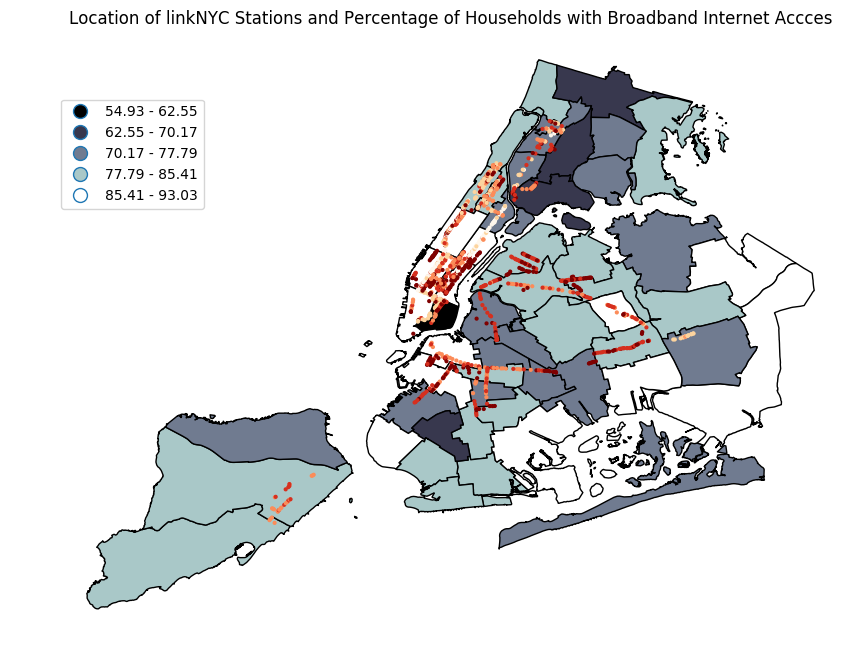

In [42]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
pumashp.plot(ax=ax, column='pcBB', cmap='bone', scheme='equal_interval', k=5, edgecolor='k', legend=True)
ax.get_legend().set_bbox_to_anchor((.2, .9))

linkNYC.plot(ax=ax, column='date_link_', marker='o', cmap='OrRd', markersize=4, scheme='equal_interval', legend=False)
ax.axis('off')
#ax.get_legend().set_bbox_to_anchor((.2, .9))
plt.title('Location of linkNYC Stations and Percentage of Households with Broadband Internet Accces')

**Figure 3:** The location of linkNYC stations plotted on a choropleth map of the percentage of households with broadband internet access distributed at the level of public use microdata areas (PUMAs), in 5 equal intervals. We notice a higher station concentration in Manhattan -where the broadband access percentage is already very high. Some of the locations with low broadband access percentages do have a linkNYC station closeby, however we can clearly notice that the majority of areas with lower access lack linkNYC stations. 

darker indicating a smaller percentage of hoses with broadband access). The color of the dots corresponding to the linkNYC dots represents the age of the hub, lighter colors (yellow) indicating older hubs, darker colors (red) indicating more recent hubs, from the earliest linkNYC location placed on 2015-12-28, to the latest ones at the time the data were gathered, placed on 2017-11-04.

### 5 Find the number of linkNYC locations per person by PUMA
#### 5.1 with the AFF API from ACS get the total population by puma and merge it into your GeoDF
the ACS population by variable is B00001_001E, and of course your geometry is PUMA, public%20use%20microdata%20area:*, as before

In [43]:
# getting the UNWEIGHTED SAMPLE COUNT OF THE POPULATION 
# https://api.census.gov/data/2016/acs/acs1/groups/B00001.html
keyPop = 'B00001_001E'
url = 'https://api.census.gov/data/2016/acs/acs1?get=' + keyPop + \
',NAME&for=public%20use%20microdata%20area:*&in=state:36&key=' + myAPI
response = requests.request('GET', url).content
pumaPop = pd.read_csv(io.StringIO(response.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [44]:
pumaPop.columns

Index(['B00001_001E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [45]:
pumaPop.drop(['NAME', 'state', 'Unnamed: 4'], axis=1, inplace=True)
pumaPop.columns = ['Population', 'public use microdata area']
pumaPop.head()

,Population,public use microdata area
0,3075,100
1,4356,200
2,2736,300
3,2722,401
4,2874,402


In [46]:
pumashp = pumashp.merge(pumaPop, left_on='puma', right_on='public use microdata area')
pumashp.head(2)

,puma,shape_area,shape_leng,geometry,NBB,NAME,state,public use microdata area_x,Nhouseholds,pcBB,Population,public use microdata area_y
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,3701
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,49817,68.310015,1959,3702


### 5.2 find the number of station per 100 people per PUMA

### Perform a spatial join

In [47]:
# convert coordinates 
pumashp_ft = pumashp.to_crs(epsg=2263)
linkNYC_ft = linkNYC.to_crs(epsg=2263)
pumashp.crs, linkNYC.crs

({'init': 'epsg:2263', 'no_defs': True},
 {'init': 'epsg:2263', 'no_defs': True})

In [49]:
pumalink = gpd.sjoin(pumashp, linkNYC).groupby('puma')['link_site'].count().reset_index()
pumalink.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [52]:
pumashp = pumashp.merge(pumalink, on='puma')
pumashp.head()

,puma,shape_area,shape_leng,geometry,NBB,NAME,state,public use microdata area_x,Nhouseholds,pcBB,Population,public use microdata area_y,link_site_x,link_site_y,link_site
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,3701,1,1,1
1,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,4015,3,3,3
2,3705,1.224951e+08,68657.316149,"POLYGON ((1019225.58178711 245263.8524169383, ...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,58706,69.425612,2011,3705,1,1,1
3,3706,4.388687e+07,51799.404183,"POLYGON ((1015266.210021974 257032.2927855904,...",34391,"NYC-Bronx Community District 7--Bedford Park, ...",36,3706,46018,74.733800,1274,3706,20,20,20
4,3707,4.228113e+07,37347.925798,"POLYGON ((1012642.970825195 252164.6224364594,...",32926,NYC-Bronx Community District 5--Morris Heights...,36,3707,46654,70.574870,1548,3707,29,29,29


In [50]:
pumashp['linkNYCp100p'] = pumashp['link_site'] * 100 / pumashp['Population']
pumashp.head(2)

,puma,shape_area,shape_leng,geometry,NBB,NAME,state,public use microdata area_x,Nhouseholds,pcBB,Population,public use microdata area_y,link_site,linkNYCp100p
0,3701,9.792852e+07,53227.144461,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,42158,84.275820,1517,3701,1,0.065920
1,4015,8.105438e+07,50007.415493,"POLYGON ((997086.4570312516 171933.9880370507,...",44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,55953,78.778618,2515,4015,3,0.119284


In [51]:
pumashp['linkNYCp100p'].describe()

count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%       0.538358
50%       1.299590
75%       1.873385
max      15.141540
Name: linkNYCp100p, dtype: float64

### plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

Text(0.5,1,'Location of linkNYC Stations and the Number of Stations per 100 people')

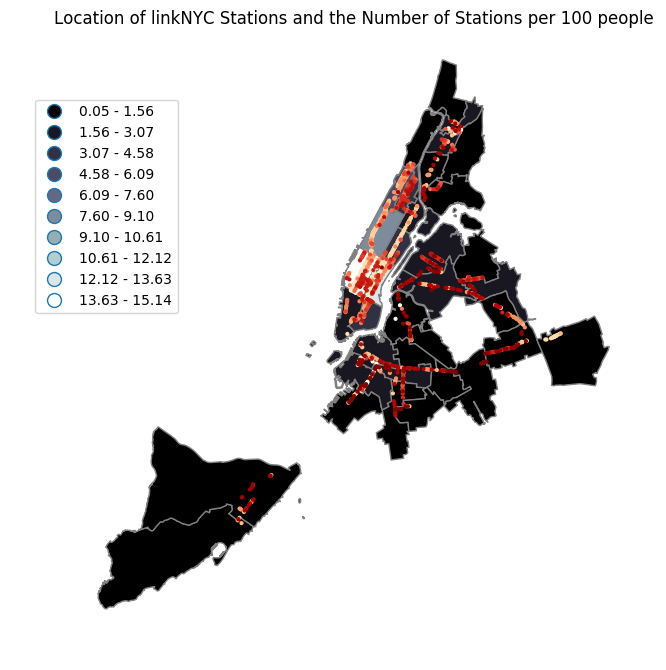

In [52]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
pumashp.plot(ax=ax, column='linkNYCp100p', cmap='bone', scheme='equal_interval', k=10, edgecolor='grey', legend=True)
linkNYC.plot(ax=ax, c=linkNYC.date_link_, marker='o', cmap='OrRd', markersize=4)
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.2, .9))
plt.title('Location of linkNYC Stations and the Number of Stations per 100 people')

**Figure 4:** The location of linkNYC stations plotted on a choropleth map showing the number of stations per 100 people. We notice that the highest concentration of stations per 100 people is around midtown Manhattan. All of the areas outside Manhattan show a very low concentration - less than 3 stations per 100 people.

The high concentration of linkNYC hubs in Manhattan is reflected by the brighter color of the PUMAs in this area: despite generally being the most populated areas, the midtown and lower Manhattan pumas have the highest number of linkNYC per inhabitant.

### Extra Credit 1:
How to make the plot better knowing that the numbers we are working with are very small.

Text(0.5,1,'Location of linkNYC Stations and the Number of Stations per 100 people')

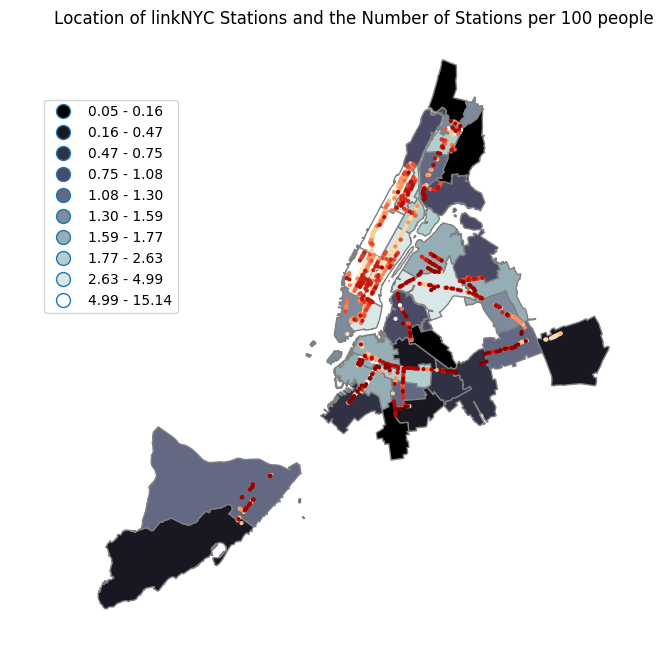

In [53]:
# http://geopandas.org/mapping.html
# changing the scheme to quantiles will better map low numbers without discarding large ones
fig, ax = plt.subplots()
ax.set_aspect('equal')
pumashp.plot(ax=ax, column='linkNYCp100p', cmap='bone', scheme='quantiles', k=10, edgecolor='grey', legend=True)
linkNYC.plot(ax=ax, c=linkNYC.date_link_, marker='o', cmap='OrRd', markersize=4)
ax.axis('off')
ax.get_legend().set_bbox_to_anchor((.2, .9))
plt.title('Location of linkNYC Stations and the Number of Stations per 100 people')

**Figure 4:** The location of linkNYC stations plotted on a choropleth map showing the number of stations per 100 people. We notice that the highest concentration of stations per 100 people is around midtown Manhattan. All of the areas outside Manhattan show a very low concentration - less than 3 stations per 100 people.

### Extra Credit 2:
plot Spatial Lag Deciles that describe the impact of linkNYC in providing access where needed. 

In [54]:
# Export shapefile
%mkdir Output
path = 'Output/pumashp.shp'
pumashp.to_file(path)

mkdir: cannot create directory ‘Output’: File exists


In [55]:
# Spatial weights
# Contiguity: Queen Weights
qW_linkNYC = ps.queen_from_shapefile(path)

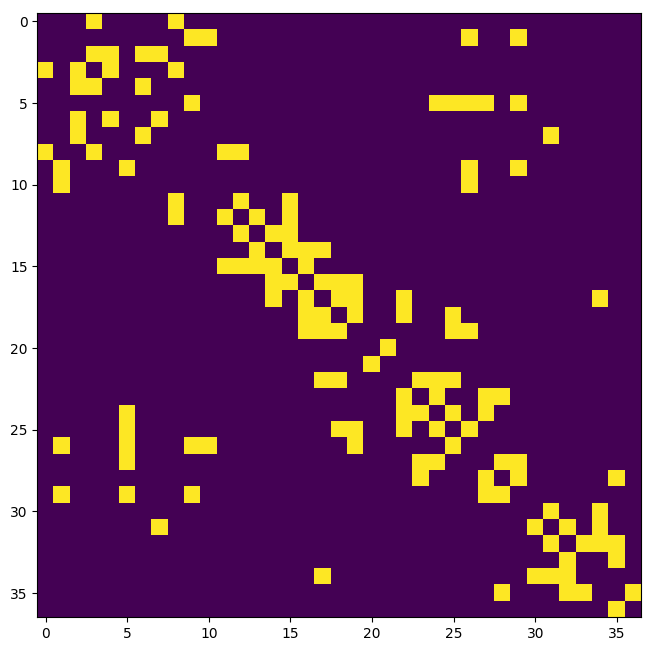

In [56]:
# Matrix of Weights
Wmatrix, ids = qW_linkNYC.full()
Wmatrix
plt.imshow(Wmatrix)

In [57]:
# change the matrix to be row-standardized
qW_linkNYC.transform = 'r'

In [58]:
# Spatial lag
linkNYC_lag = ps.lag_spatial(qW_linkNYC, pumashp.linkNYCp100p)

In [59]:
# Create Quantiles for maping
linkNYC_lag_Q10 = ps.Quantiles(linkNYC_lag, k=10)
linkNYC_lag_Q10

              Quantiles              
 
Lower          Upper            Count
        x[i] <= 0.672               4
0.672 < x[i] <= 0.916               4
0.916 < x[i] <= 0.974               3
0.974 < x[i] <= 1.077               4
1.077 < x[i] <= 1.280               4
1.280 < x[i] <= 1.618               3
1.618 < x[i] <= 3.122               4
3.122 < x[i] <= 4.432               3
4.432 < x[i] <= 6.176               4
6.176 < x[i] <= 9.704               4

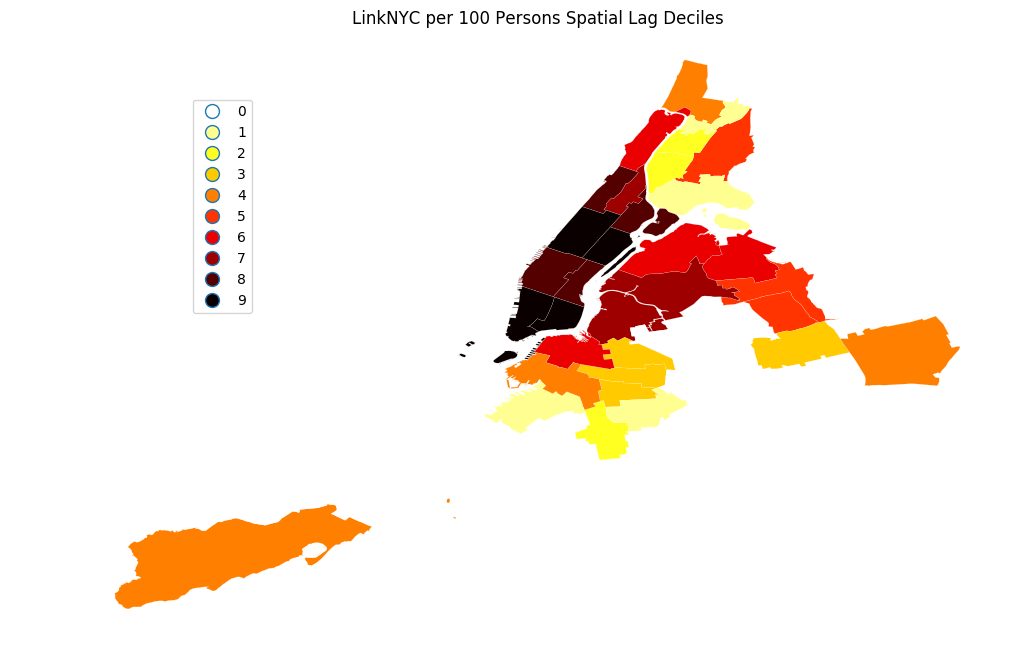

In [60]:
# Map the monthly rides lag
fig, ax = plt.subplots()
pumashp.assign(cl=linkNYC_lag_Q10.yb).plot(column='cl', categorical=True, k=10, cmap='hot_r',\
                                          linewidth=0.1, ax=ax, edgecolor='white', legend=True)
ax.axis('off')
plt.title('LinkNYC per 100 Persons Spatial Lag Deciles')
ax.get_legend().set_bbox_to_anchor((.2, .9))

**Figure 5:** Plotting the Spatial Lag Deciles we notice that the variable which is the number of LinkNYC stations per 100 people show similar values in different nighborhoods in midtown and lower Manhattan (high spatial correlation > 9). On the other hand, as we move away from these two areas we notice how the values of the variable become different indicating low spatial correlation. For example two adjacent areas one colored deep red and the other yellow show a very low spatial correlation. These disparities in the value of our variable in different areas indicate the need for a more just distribution of the LinkNYC stations across the different boroughs.

# Federica's work

In [63]:
# the weight matrix
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [64]:
qW_CT.transform = 'r'
pumashplc["linkNYCpponBBpercentagesq"] = (pumashplc["linkNYCpp"] / 
                                          (pumashplc.pcBB / 100))
linkedNYCLag = ps.lag_spatial(qW_CT, pumashplc["linkNYCpponBBpercentagesq"])

linkedNYCpc = ps.Percentiles(linkedNYCLag.squeeze(), [0,25,50,75,100])
linkedNYCpc.yb

array([2, 2, 1, 1, 2, 1, 3, 2, 3, 3, 3, 1, 2, 4, 3, 2, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 1, 3, 4, 2, 3, 4, 3, 2, 2, 2, 1, 1, 1, 4, 3, 2, 1,
       1, 2, 3, 3, 4, 3, 2, 1, 2, 0, 1])

In [65]:
pumashplc["sqlinkNYCpponBBpercentagesq"] = (np.sqrt(pumashplc["linkNYCpp"])**0.5 / 
                                            (pumashplc.pcBB / 100)**2)
linkedNYCLag2 = ps.lag_spatial(qW_CT, pumashplc["sqlinkNYCpponBBpercentagesq"])
linkedNYCpc2 = ps.Percentiles(linkedNYCLag2.squeeze(), [0,25,50,75,100])
linkedNYCpc2.yb

array([3, 1, 1, 1, 2, 1, 3, 2, 4, 3, 4, 2, 2, 4, 2, 1, 4, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 1, 3, 4, 3, 3, 4, 3, 2, 2, 3, 2, 1, 1, 3, 3, 2, 1,
       1, 2, 2, 2, 3, 3, 2, 1, 2, 0, 1])

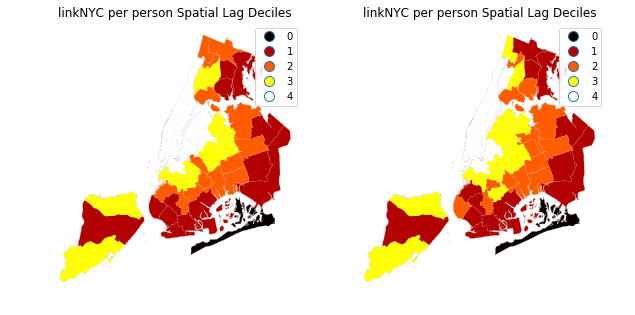

In [66]:
#f, ax = plt.subplots(figsize=(9, 9))
f = pl.figure(figsize=(10, 5))
ax = f.add_subplot(121)
pumashp.plot(color='white', edgecolor='black', ax=ax, lw=0.1)
pumashplc.assign(cl=linkedNYCpc.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("linkNYC per person Spatial Lag Deciles");
ax = f.add_subplot(122)
pumashp.plot(color='white', edgecolor='black', ax=ax, lw=0.1)
pumashplc.assign(cl=linkedNYCpc2.yb).plot(column='cl', categorical=True, 
        k=5, cmap='hot', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("linkNYC per person Spatial Lag Deciles");

##### Fig. 7: Two metrics of the impact of linkNYC hubs,  constructed one, *on the left*, as the ratio of linkNYC per 100 inhabitants ($N_{linkNYC_{100}}$) over the fraction of houses with broadband access ($f_{BB}$): $ \frac{N_{linkNYC_{100}}}{f_{BB}}$ and *on the right*  the square root of the linkNYC hubs per 100 people over the square of the  fraction of houses with broadband access. $ \frac{\sqrt{N_{linkNYC_{100}}}}{f_{BB}^2}$, giving less weight to the presence of linkNYC hubs and more wight to the BB fraction. Both are aggregated and plotted as  spatial lag deciles (the average of the values for the neighbouring regions) with queen's weights (Anselin, Rey & Li 2014) at the PUMA geographic granularity level.  Small differences are visible in the impact of linkNYC in the Bronx and in Brooklyn,  where the second metric shows a higher impact, and Queens where the impact measured by the second metric is less.   Colors from black through red and yellow to white indicate higher impact of linkNYC as defined above. The area of highest impact are in Manhattan and the Brooklyn PUMAs that face the East river: with this metric the linkNYC aboundance in midtown Manhattan dominates the metric. 